<h1>Softmax Regression on MNIST</h1>

<h3>Imports</h3>

In [26]:
import torch
import time
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<h3>Preprocessing the data</h3>

In [28]:
# normalizing the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


<h3>Downloading the dataset</h3>

In [29]:
train_val_dataset = datasets.MNIST(root='./dataset', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./dataset', train=False, download=False, transform=transform)
combined_dataset = ConcatDataset([train_val_dataset, test_dataset])


In [30]:
print(f"Train dataset size: {len(train_val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")

Train dataset size: 60000
Test dataset size: 10000
Combined dataset size: 70000


In [31]:
# print(combined_dataset[0][0].shape)
# print(combined_dataset[0][1])
# x, y= combined_dataset[0]
# print(x.shape)
# print("x= ", x)
# print(y)
# plt.imshow(x[0], cmap='gray')

<h3>HyperParameters</h3>

In [32]:
batch_size = 64
learning_rate = 0.01
num_classes = 10
input_size = 28 * 28
num_epochs = 10

<h3>Splitting the data</h3>

In [33]:
#calculating split sizes
train_datset_size = int(0.6 * len(combined_dataset))
val_dataset_size = int(0.2 * len(combined_dataset))
test_dataset_size = len(combined_dataset) - train_datset_size - val_dataset_size

#printing split sizes
print(train_datset_size, val_dataset_size, test_dataset_size)

42000 14000 14000


In [34]:
# splitting the dataset
train_dataset_idx, temp_dataset_idx = train_test_split(list(range(len(combined_dataset))), train_size=train_datset_size, random_state=5)
val_dataset_idx, test_dataset_idx = train_test_split(temp_dataset_idx, test_size=0.5, random_state=5)

print(len(train_dataset_idx), len(val_dataset_idx), len(test_dataset_idx))

42000 14000 14000


In [35]:
train_dataset = Subset(combined_dataset, train_dataset_idx)
val_dataset = Subset(combined_dataset, val_dataset_idx)
test_dataset = Subset(combined_dataset, test_dataset_idx)

print(len(train_dataset), len(val_dataset), len(test_dataset))

42000 14000 14000


In [36]:
# creating dataloaders
train_dataset_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataset_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_dataset_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(len(train_dataset_loader), len(val_dataset_loader), len(test_dataset_loader))

657 219 219


In [37]:
x, y = next(iter(train_dataset_loader))

print(x.shape)
print(y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


<h3>Softmax Regression Model</h3>

<h2>Define the softmax regression model</h2>

- Define the main layer, this is the main layer of the softmax regression model, which computes (Wx+b)
- MNIST images are 28x28 pixels, 10 classes
```
self.linear = torch.nn.Linear(input_size, num_classes)
```
- The forward pass that defines how the input data flows through the model

In [38]:
class SoftmaxRegressionModel(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the images
        return self.linear(x)

<h3>Initialize model, loss function, and optimizer:</h3>
- Model: Softmax Regression <br/>
- Loss Function: Cross-Entropy <br/>
- Optimizer: Stochastic Gradient Descent (SGD) <br/>

In [39]:
model = SoftmaxRegressionModel(input_size, num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), learning_rate, weight_decay=1e-4)

<h3>Training and Evaluation</h3>

- Training Loop: <br/>
```
for epoch in range(num_epochs):
    model.train()
```

- **y_train** is the ground truth label for the current batch
- **outputs** is the predicted label for the current batch

- clear the gradients of all optimized variables to prevent accumulation of gradients from previous batches
```
    optimizer.zero_grad()
```

- forward pass of the model on the current batch
```
    outputs = model(x_train)
```

- compute the loss between the predicted label (outputs) and the ground truth label (y_train)
```
    loss = criterion(outputs, y_train)
```

- compute the gradients of the loss with respect to the model parameters

```
loss.backward()
```
- update the model parameters based on the computed gradients
```
optimizer.step()
```

In [40]:
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch_idx, (x_train, y_train) in enumerate(train_dataset_loader):
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward() 
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataset_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x_val, y_val in val_dataset_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

    val_loss /= len(val_dataset_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * (correct / total)
    val_accuracies.append(val_accuracy)

    # Logging
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}%")


Epoch 1/10
Training Loss: 0.6773
Validation Loss: 0.4722
Validation Accuracy: 87.0857%
Epoch 2/10
Training Loss: 0.4110
Validation Loss: 0.3855
Validation Accuracy: 89.1286%
Epoch 3/10
Training Loss: 0.3682
Validation Loss: 0.3596
Validation Accuracy: 89.7286%
Epoch 4/10
Training Loss: 0.3464
Validation Loss: 0.3423
Validation Accuracy: 90.1714%
Epoch 5/10
Training Loss: 0.3331
Validation Loss: 0.3346
Validation Accuracy: 90.3857%
Epoch 6/10
Training Loss: 0.3233
Validation Loss: 0.3286
Validation Accuracy: 90.4929%
Epoch 7/10
Training Loss: 0.3158
Validation Loss: 0.3250
Validation Accuracy: 90.4500%
Epoch 8/10
Training Loss: 0.3100
Validation Loss: 0.3190
Validation Accuracy: 90.8429%
Epoch 9/10
Training Loss: 0.3053
Validation Loss: 0.3159
Validation Accuracy: 90.8214%
Epoch 10/10
Training Loss: 0.3009
Validation Loss: 0.3093
Validation Accuracy: 91.1571%


<h3>Visualizations</h3>

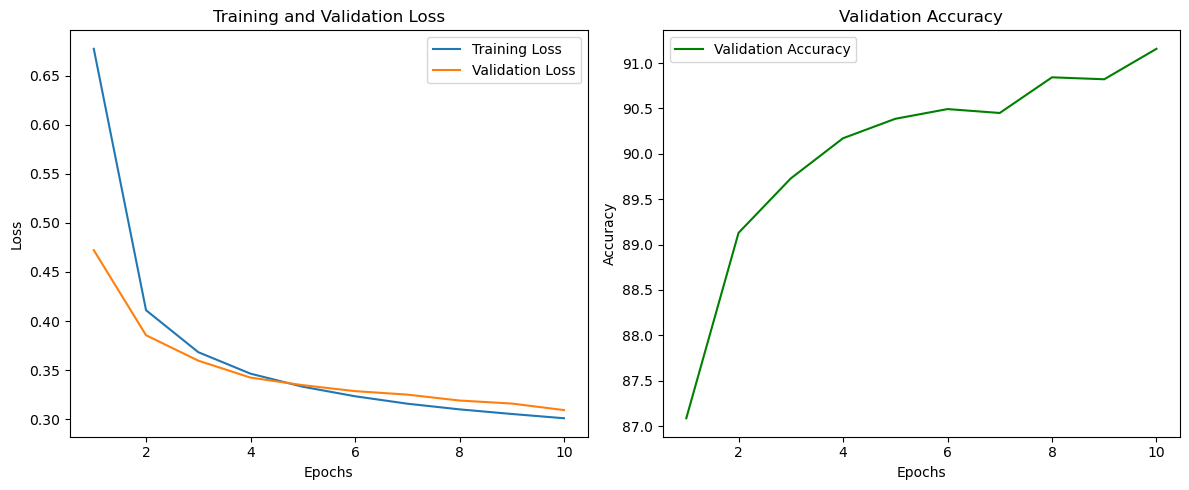

In [41]:
epochs = range(1, num_epochs + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<h3>Confusion Matrix</h3>

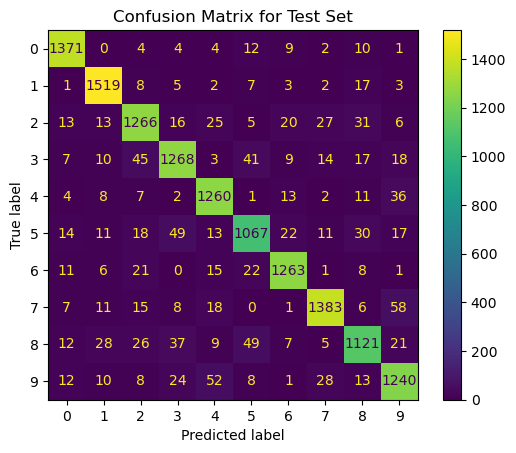

In [42]:
# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for x_test, y_test in test_dataset_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        outputs = model(x_test)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))

# Plot confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix for Test Set")
plt.show()